# Physics Informed Neural Networks (PINNs) in PhysicsNeMo Sym from Nvidia PhysicsNeMo framework #

Problem statement:
$$\begin{split}    \mathbf{P} : \left\{\begin{matrix}
\frac{\delta^2 u}{\delta x^2}(x) = f(x), \\ \\ u(0) = u(1) = 0,
\end{matrix}\right.\end{split}$$

Given:
$$ f(x) = 1 $$

We can define the boundary errors as previously mentions in intro_examples.ipynb <br>
While the residual loss is: 
$$L_{residual} = \frac{1}{N}\sum^{N}_{i=0} \left( \frac{\delta^2
  u_{net}}{\delta x^2}(x_i) - f(x_i) \right)^2$$

The framework suggests using monte-carlo integration for approximation of residual loss.
$$L_{residual} = \int^1_0 \left( \frac{\delta^2 u_{net}}{\delta x^2}(x) - f(x) \right)^2 dx$$

As:

$$\int^1_0 \left( \frac{\delta^2 u_{net}}{\delta x^2}(x) - f(x) \right)^2 dx \approx (\int^1_0 dx) \frac{1}{N} \sum^{N}_{i=0} \left( \frac{\delta^2 u_{net}}{\delta x^2}(x_i) - f(x_i) \right)^2 = \frac{1}{N} \sum^{N}_{i=0} \left( \frac{\delta^2 u_{net}}{\delta x^2}(x_i) - f(x_i) \right)^2$$

## Now let's try implementing the example explored in the reference ##

### Import modules ###

In [1]:
# Imports
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt

### Define model class ###

In [2]:
class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out

### define initial conditions and double derivative ###

In [3]:
# Initial conditions
u0 = 0
u1 = 0

In [4]:
domain = [0.0, 1.0]
# training points
x = torch.linspace(domain[0], domain[1], steps=100, requires_grad=True).reshape(-1, 1)

In [5]:
import torch

def compute_loss(model: torch.nn.Module,
                 x_pde: torch.Tensor,
                 x_bc: torch.Tensor,
                 w_pde: float = 1.0, 
                 w_bc: float = 100.0) -> torch.Tensor:
    
    # PDE Loss Calculation (d^2u/dx^2 - 1 = 0)
    x_pde.requires_grad_(True)
    u_hat = model(x_pde)

    # create_graph=True is necessary to calculate the second derivative later
    du_dx = torch.autograd.grad(
        u_hat, x_pde, 
        grad_outputs=torch.ones_like(u_hat), 
        create_graph=True, 
        retain_graph=True
    )[0]

    # Compute the SECOND derivative (d^2u/dx^2)
    d2u_dx2 = torch.autograd.grad(
        du_dx, x_pde, 
        grad_outputs=torch.ones_like(du_dx), 
        create_graph=True
    )[0]
    
    pde_residual = d2u_dx2 - 1.0
    
    # Calculate the PDE loss (Mean Squared Error)
    ode_loss = torch.mean(pde_residual**2)
    
    # Boundary Condition (BC) Loss Calculation 
    
    # x_bc should contain the boundary points: torch.tensor([[0.0], [1.0]])
    u_bc_hat = model(x_bc)
    
    # The target values are u(0)=0 and u(1)=0
    u_bc_target = torch.zeros_like(u_bc_hat) 
    
    # Calculate the BC loss
    bc_loss = torch.mean((u_bc_hat - u_bc_target)**2)
    # Use weighting (w_bc is often > w_pde for stability)
    total_loss = w_pde * ode_loss + w_bc * bc_loss
    return total_loss

In [6]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = compute_loss(model = model, x_pde = x, x_bc = torch.tensor([[0.0], [1.0]]))
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.2968342304229736
Epoch 500, Loss: 0.00038605291047133505
Epoch 1000, Loss: 0.002597855869680643
Epoch 1500, Loss: 0.00018837020616047084


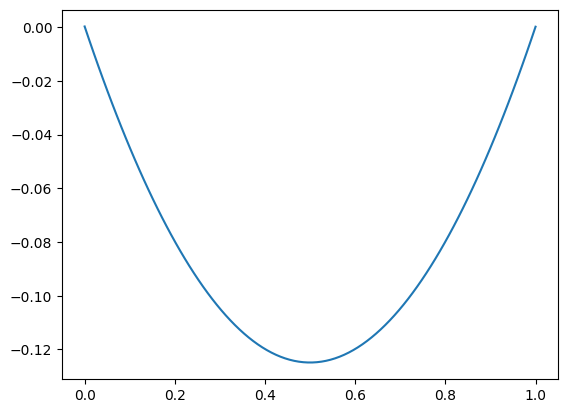

In [7]:
# plotting
fig, ax = plt.subplots()
ax.plot(x.detach().numpy(), model(x).detach().numpy(), label='PINN Solution')

### See this is expected from the normal approach, now let's add in monte carlo integration ###

In [8]:
def get_mc_points(n_points: int):
    """"Generate random points for Monte Carlo integration"""
    x = torch.rand((n_points, 1), requires_grad = True)
    return x

def compute_monte_ode_loss(num_samples=1000, 
                           model=simple_NN(), 
                           x_bc=torch.tensor([[0.0], [1.0]])):
    x = get_mc_points(num_samples)
    u = model(x)
    du_dx = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    d2u_dx2 = torch.autograd.grad(
        du_dx, x,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True
    )[0]
    residual = d2u_dx2 - 1.0
    ode_loss = torch.mean(residual**2)
    # Boundary Condition (BC) Loss Calculation 
    
    # x_bc should contain the boundary points: torch.tensor([[0.0], [1.0]])
    u_bc_hat = model(x_bc)
    
    # The target values are u(0)=0 and u(1)=0
    u_bc_target = torch.zeros_like(u_bc_hat) 
    
    # Calculate the BC loss
    bc_loss = torch.mean((u_bc_hat - u_bc_target)**2)

    total_loss = ode_loss + 100.0 * bc_loss

    return total_loss


In [9]:
mc_model = simple_NN()
mc_optimizer = torch.optim.Adam(mc_model.parameters(), lr=0.01)

for epoch in range(2000):
    loss = compute_monte_ode_loss(model=mc_model)
    mc_optimizer.zero_grad()
    loss.backward()
    mc_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Monte Carlo Loss: {loss.item()}")

Epoch 0, Monte Carlo Loss: 2.0142123699188232
Epoch 500, Monte Carlo Loss: 0.0005933169741183519
Epoch 1000, Monte Carlo Loss: 0.00017936328367795795
Epoch 1500, Monte Carlo Loss: 5.232356852502562e-05


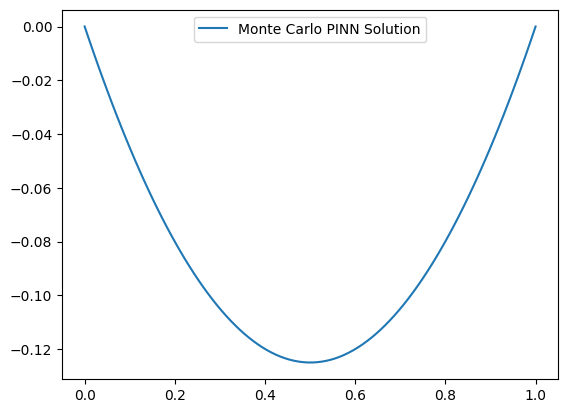

In [10]:
fig, ax = plt.subplots()
ax.plot(x.detach().numpy(), mc_model(x).detach().numpy(), label='Monte Carlo PINN Solution')
ax.legend()